In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from __future__ import division

from collections import defaultdict
import pickle
import os
import uuid
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import animation

from sensei import utils
from sensei.obs_models import EncoderObsModel, EncoderUserObsModel
from sensei.user_models import CLFUser
from sensei.guide_models import CLFGuide
from sensei.envs import CLFEnv, GuideEnv
from sensei import ase

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sess = utils.make_tf_session(gpu_mode=False)

In [ ]:
data_dir = utils.clf_data_dir
fig_dir = os.path.join(data_dir, 'figures')

create mnist env

In [ ]:
dataset = utils.make_mnist_dataset()

In [ ]:
max_ep_len = 28

In [ ]:
env = CLFEnv(dataset, max_ep_len=max_ep_len)

In [ ]:
env.shuffle_obs_idxes = True
rollouts = utils.evaluate_policy(sess, env, env.oracle_policy, n_eval_rollouts=10000)['rollouts']
env.shuffle_obs_idxes = False
data = utils.vectorize_rollouts(rollouts, env.max_ep_len, preserve_trajs=True)
data = utils.split_rollouts(data)

In [ ]:
data['obses'].shape

In [ ]:
encoder_data_path = os.path.join(data_dir, 'encoder_data.pkl')

In [ ]:
with open(encoder_data_path, 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(encoder_data_path, 'rb') as f:
  data = pickle.load(f)

In [ ]:
encoder_model_kwargs = {
  'scope_file': os.path.join(data_dir, 'encoder_scope.pkl'),
  'tf_file': os.path.join(data_dir, 'encoder.tf'),
  'n_hidden': 32
}

encoder_train_kwargs = {
  'iterations': 5000,
  'ftol': 1e-6,
  'batch_size': 32,
  'learning_rate': 1e-2,
  'val_update_freq': 100,
  'verbose': True
}

In [ ]:
encoder = EncoderObsModel(sess, env, **encoder_model_kwargs)

In [ ]:
encoder.train(data, **encoder_train_kwargs)

In [ ]:
encoder.save()

In [ ]:
encoder.load()

In [ ]:
internal_encoder_model_kwargs = {
  'scope_file': os.path.join(data_dir, 'internal_encoder_scope.pkl'),
  'tf_file': os.path.join(data_dir, 'internal_encoder.tf'),
  'n_hidden': 32,
  'n_classes': dataset['n_classes'],
  'n_layers': 0,
  'final_action_only': False
}

internal_encoder_train_kwargs = {
  'iterations': 5000,
  'ftol': 1e-6,
  'batch_size': 32,
  'learning_rate': 1e-2,
  'val_update_freq': 100,
  'verbose': True
}

In [ ]:
internal_encoder = EncoderUserObsModel(sess, env, **internal_encoder_model_kwargs)

In [ ]:
internal_encoder.train(data, **internal_encoder_train_kwargs)

In [ ]:
internal_encoder.save()

In [ ]:
internal_encoder.load()

create guide env

In [ ]:
encoder_for_user = EncoderUserObsModel(sess, env, **internal_encoder_model_kwargs)
encoder_for_user.load()
user_model = CLFUser(encoder_for_user)

In [ ]:
guide_env = GuideEnv(env, user_model)

In [ ]:
iden_guide_policy = utils.CLFIdenPolicy()
unif_guide_policy = utils.CLFUnifPolicy(env)

In [ ]:
encoder_for_oracle = EncoderUserObsModel(sess, env, **internal_encoder_model_kwargs)
encoder_for_oracle.load()

oracle_guide_model = CLFGuide(
  sess,
  env,
  encoder_for_oracle
)

In [ ]:
encoder_for_naive = EncoderObsModel(sess, env, **encoder_model_kwargs)
encoder_for_naive.load()

naive_guide_model = CLFGuide(
  sess,
  env,
  encoder_for_naive
)

sanity-check envs, agents

In [ ]:
env.render_mode = True

In [ ]:
guide_env.reset_init_order()

In [ ]:
rollout = utils.run_ep(iden_guide_policy, guide_env, render=True)

In [ ]:
guide_env.close()

In [ ]:
guide_env.reset_init_order()

In [ ]:
rollout = utils.run_ep(unif_guide_policy, guide_env, render=True)

In [ ]:
guide_env.close()

In [ ]:
guide_env.reset_init_order()

In [ ]:
rollout = utils.run_ep(oracle_guide_model, guide_env, render=True)

In [ ]:
guide_env.close()

In [ ]:
guide_env.reset_init_order()

In [ ]:
rollout = utils.run_ep(naive_guide_model, guide_env, render=True)

In [ ]:
guide_env.close()

In [ ]:
mnistviz_path = os.path.join(data_dir, 'mnist-viz.pkl')

In [ ]:
with open(mnistviz_path, 'rb') as f:
  rollouts = pickle.load(f)

In [ ]:
def markup_rollout(rollout):
  feats = rollout[0][-1]['goal']
  shown_obs_idxes = []
  for t, x in enumerate(rollout[:-1]):
    obs_idx = utils.onehot_decode(x[1][:env.max_ep_len])
    shown_obs_idxes.append(obs_idx)
    img = env.mask_img(shown_obs_idxes, feats)
    rollout[t][-1]['img'] = img[:, :, 0]
  img = env.mask_img(list(range(env.max_ep_len)), feats)
  rollout[-1][-1]['img'] = img[:, :, 0]
  return rollout

In [ ]:
rollouts = [markup_rollout(rollout) for rollout in rollouts]

In [ ]:
guides = [iden_guide_policy, unif_guide_policy, naive_guide_model, oracle_guide_model]
rollouts = []
for guide in guides:
  guide_env.reset_init_order()
  rollout = utils.run_ep(guide, guide_env, render=True)
  rollouts.append(rollout)

In [ ]:
with open(mnistviz_path, 'wb') as f:
  pickle.dump(rollouts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
all_imgs = []
T = 7#28
for i, rollout in enumerate(rollouts[:-1]):
  imgs = []
  for j, x in enumerate(rollout[:T]):
    img = deepcopy(x[-1]['img'])
    img[0, :] = 1
    if i > 1:
      img[-1, :] = 1
    img[:, 0] = 1
    if j == T-1:
      img[:, -1] = 1
    imgs.append(img)
  all_imgs.append(np.concatenate(imgs, axis=1))
img = np.concatenate(all_imgs, axis=0)

plt.imshow(img, cmap=mpl.cm.binary)
plt.axis('off')
#plt.savefig(os.path.join(fig_dir, 'clf-viz-crop.pdf'), bbox_inches='tight', dpi=500)
#plt.savefig(os.path.join(fig_dir, 'clf-viz.pdf'), bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
img = imgs[-1]
plt.imshow(img, cmap=mpl.cm.binary, norm=mpl.colors.Normalize(vmin=0.,vmax=1.))
plt.axis('off')
plt.savefig(os.path.join(fig_dir, 'clf-final-viz.pdf'), bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
all_imgs = []
rollout = rollouts[-1]
imgs = []
for x in rollout:
  img = x[-1]['img']
  img[0, :] = 1
  img[-1, :] = 1
  img[:, 0] = 1
  img[:, -1] = 1
  imgs.append(img)
all_imgs.append(np.concatenate(imgs, axis=1))
img = np.concatenate(all_imgs, axis=0)
plt.imshow(img, cmap=mpl.cm.binary, norm=mpl.colors.Normalize(vmin=0.,vmax=1.))
plt.axis('off')
plt.savefig(os.path.join(fig_dir, 'clf-viz-example.png'), bbox_inches='tight', dpi=500)
plt.show()

evaluate baselines

In [ ]:
env.render_mode = True

In [ ]:
guides = {
  'iden': iden_guide_policy,
  'unif': unif_guide_policy,
  'oracle': oracle_guide_model,
  'naive': naive_guide_model
}

In [ ]:
baseline_guide_evals = ase.evaluate_baseline_guides(
  sess, 
  guide_env, 
  guides, 
  n_eval_rollouts=5000
)

In [ ]:
def animate_frames(frames):
  fig = plt.figure(figsize=(10, 10))
  plt.axis('off')
  ims = [[plt.imshow(frame, animated=True, cmap=mpl.cm.binary, norm=mpl.colors.Normalize(vmin=0.,vmax=1.))] for frame in frames]
  plt.close()
  anim = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=1000)
  return anim

In [ ]:
cat_frames = []
gap = np.zeros((28, 1))
for rollout_idx in range(10):
  frames = []
  for guide_name in ['iden', 'unif', 'naive']:
    rollout = markup_rollout(baseline_guide_evals[guide_name]['rollouts'][rollout_idx])
    frames.append([x[-1]['img'] for x in rollout])
  final_img = frames[-1][-1]
  for frame_set in zip(*frames):
    gapped_frames = []
    for i, frame in enumerate(frame_set):
      gapped_frames.append(frame)
      gapped_frames.append(gap)
    gapped_frames.append(final_img)
    cat_frames.append(np.concatenate(gapped_frames, axis=1))
anim = animate_frames(cat_frames)
anim.save(os.path.join(fig_dir, 'mnist-short.mp4'))

In [ ]:
baselines_eval_path = os.path.join(data_dir, 'baselines_eval.pkl')

In [ ]:
with open(baselines_eval_path, 'wb') as f:
  pickle.dump(baseline_guide_evals, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(baselines_eval_path, 'rb') as f:
  baseline_guide_evals = pickle.load(f)

In [ ]:
for k, v in baseline_guide_evals.items():
  print(k, {x: y for x, y in v['perf'].items() if not x.endswith('_t')})

In [ ]:
mpl.rcParams.update({'font.size': 18})

In [ ]:
label_of_perf_met = {
  'succ': 'Classification Accuracy',
  'user_belief_in_true_state': 'Log-Likelihood of True Label'
}

user study

In [ ]:
n_users = 12

In [ ]:
n = sum(len(rollout) for guide_eval in baseline_guide_evals.values() for rollout in guide_eval['rollouts'])
n, n/n_users

In [ ]:
app_dir = os.path.join(utils.sensei_dir, 'labeling')

In [ ]:
def url_of_img_file(img_file):
  return 'http://localhost:5000/imgs/%s.png' % img_file

In [ ]:
# BEGIN SETUP

In [ ]:
img_file_of_metadata = {}
ordered_img_files_of_user = [[] for _ in range(n_users)]
num_rollouts = [len(guide_eval['rollouts']) for guide_eval in baseline_guide_evals.values()]
assert all(x == num_rollouts[0] for x in num_rollouts[1:])
num_rollouts = num_rollouts[0]
user = 0
for rollout_idx in range(num_rollouts):
  shuffled_guide_names = list(baseline_guide_evals.keys())
  np.random.shuffle(shuffled_guide_names)
  for guide_name in shuffled_guide_names:
    guide_eval = baseline_guide_evals[guide_name]
    rollout = guide_eval['rollouts'][rollout_idx]
    for t, x in enumerate(rollout):
      img = x[-1]['img']
      img_file = str(uuid.uuid4())
      ordered_img_files_of_user[user].append(img_file)
      print([len(img_files) for img_files in ordered_img_files_of_user], n)
      metadata = (guide_name, rollout_idx, t)
      img_file_of_metadata[metadata] = img_file
      plt.imshow(img, cmap=mpl.cm.binary, norm=mpl.colors.Normalize(vmin=0.,vmax=1.))
      plt.axis('off')
      plt.savefig(os.path.join(app_dir, 'imgs', '%s.png' % img_file), bbox_inches='tight', dpi=50)
      plt.close()
    user = (user + 1) % n_users

In [ ]:
with open(os.path.join(app_dir, 'img_file_of_metadata.pkl'), 'wb') as f:
  pickle.dump(img_file_of_metadata, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
for user, ordered_img_files in enumerate(ordered_img_files_of_user):
  unlabeled_img_urls = [url_of_img_file(img_file) for img_file in ordered_img_files[::-1]]
  
  user_dir = os.path.join(app_dir, 'users', str(user))
  if not os.path.exists(user_dir):
    os.makedirs(user_dir)
    
  with open(os.path.join(user_dir, 'unlabeled_img_urls.pkl'), 'wb') as f:
    pickle.dump(unlabeled_img_urls, f, pickle.HIGHEST_PROTOCOL)
    
  with open(os.path.join(user_dir, 'labels.csv'), 'w+') as f:
    f.write('')

In [ ]:
# END SETUP

In [ ]:
label_of_img_url = {}
user_of_img_url = {}
for user in range(n_users):
  with open(os.path.join(app_dir, 'users', str(user), 'labels.csv'), 'r+') as f:
    for line in f:
      img_url, label = line.split('\n')[0].split(',')
      label_of_img_url[img_url] = label
      user_of_img_url[img_url] = user

In [ ]:
with open(os.path.join(app_dir, 'img_file_of_metadata.pkl'), 'rb') as f:
  img_file_of_metadata = pickle.load(f)

In [ ]:
for guide_name, guide_eval in baseline_guide_evals.items():
  for rollout_idx, rollout in enumerate(guide_eval['rollouts']):
    metadata = (guide_name, rollout_idx, len(rollout)-1)
    img_file = img_file_of_metadata[metadata]
    img_url = url_of_img_file(img_file)
    action = label_of_img_url.get(img_url, None)
    if action is None:
      label = rollout[0][0]
    else:
      label = action
    
    time_to_label = np.nan
    for t, x in enumerate(rollout):
      step = baseline_guide_evals[guide_name]['rollouts'][rollout_idx][t]
      step = list(step)
      metadata = (guide_name, rollout_idx, t)
      if metadata not in img_file_of_metadata:
        succ = np.nan
      else:
        img_file = img_file_of_metadata[metadata]
        img_url = url_of_img_file(img_file)
        action = label_of_img_url.get(img_url, None)
        if action is None:
          succ = np.nan
        elif action == 'idk':
          succ = 0.1
        else:
          succ = 1 if int(action) == int(label) else 0
        if succ == 1 and np.isnan(time_to_label):
          time_to_label = t
        elif succ == 0:
          time_to_label = np.nan
        step[-1]['user'] = user_of_img_url.get(img_url, None)
      step[-1]['succ'] = succ
      if t == len(rollout) - 1:
        step[-1]['time_to_label'] = time_to_label
      baseline_guide_evals[guide_name]['rollouts'][rollout_idx][t] = tuple(step)
  baseline_guide_evals[guide_name]['perf'] = utils.compute_perf_metrics(baseline_guide_evals[guide_name]['rollouts'], env)

In [ ]:
metric = 'succ'
plt.title('MNIST')
plt.xlabel('Fraction of Image Revealed')
ylabel = label_of_perf_met[metric]
plt.ylabel(ylabel)

for guide_name in ['iden', 'unif', 'naive']:
  guide_eval = baseline_guide_evals[guide_name]
  xs = np.arange(1, max_ep_len + 1, 1) / max_ep_len
  ys = np.array(guide_eval['perf']['%s_t' % metric])
  yerrs = np.array(guide_eval['perf']['%s_stderr_t' % metric])
  
  idxes = list(range(7))
  xs = xs[idxes]
  ys = ys[idxes]
  yerrs = yerrs[idxes]
  
  if guide_name == 'naive':
    label = 'ASE (Our Method)'
    color = 'orange'
  else:
    label = utils.label_of_guide[guide_name]
    color = utils.color_of_guide[guide_name]
  plt.errorbar(x=xs, y=ys, yerr=yerrs, label=label, color=color, capsize=5)
  
plt.legend(loc='upper left', prop={'size': 14})
save_path = os.path.join(fig_dir, 'mnist-user-study-crop.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [ ]:
n_users = 12
depvar = 'response'
subject = 'user_id'
within = 'condition'
rows = []

for guide_name in ['unif', 'naive']:
  guide_eval = baseline_guide_evals[guide_name]
  for rollout_idx, rollout in enumerate(guide_eval['rollouts']):
    metadata = (guide_name, rollout_idx, len(rollout)-1)
    img_file = img_file_of_metadata[metadata]
    img_url = url_of_img_file(img_file)
    action = label_of_img_url.get(img_url, None)
    if action is None:
      continue
    label = action
    
    for t, x in enumerate(rollout):
      metadata = (guide_name, rollout_idx, t)
      if metadata in img_file_of_metadata and img_url in user_of_img_url:
        user_id = user_of_img_url[img_url]
        img_file = img_file_of_metadata[metadata]
        img_url = url_of_img_file(img_file)
        action = label_of_img_url.get(img_url, None)
        if action is None:
          continue
        elif action == 'idk':
          succ = 0.1
        else:
          succ = 1 if int(action) == int(label) else 0
        frac_revealed = (t + 1) / 28
        digit_id = rollout_idx
        subject_id = user_id
        rows.append({subject: subject_id, depvar: succ, within: guide_name, 'frac_revealed': frac_revealed, 'digit_id': digit_id})
        
data = pd.DataFrame(rows)

In [ ]:
data.to_csv(os.path.join(data_dir, 'mnist_user_study.csv'), index=False) # for JMP

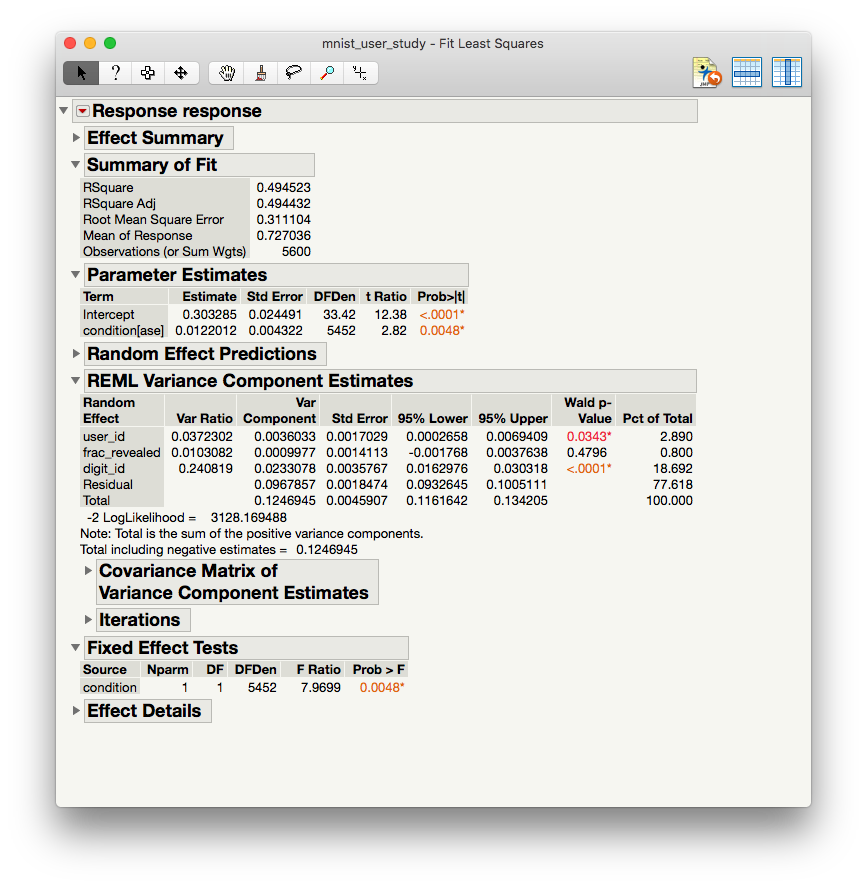

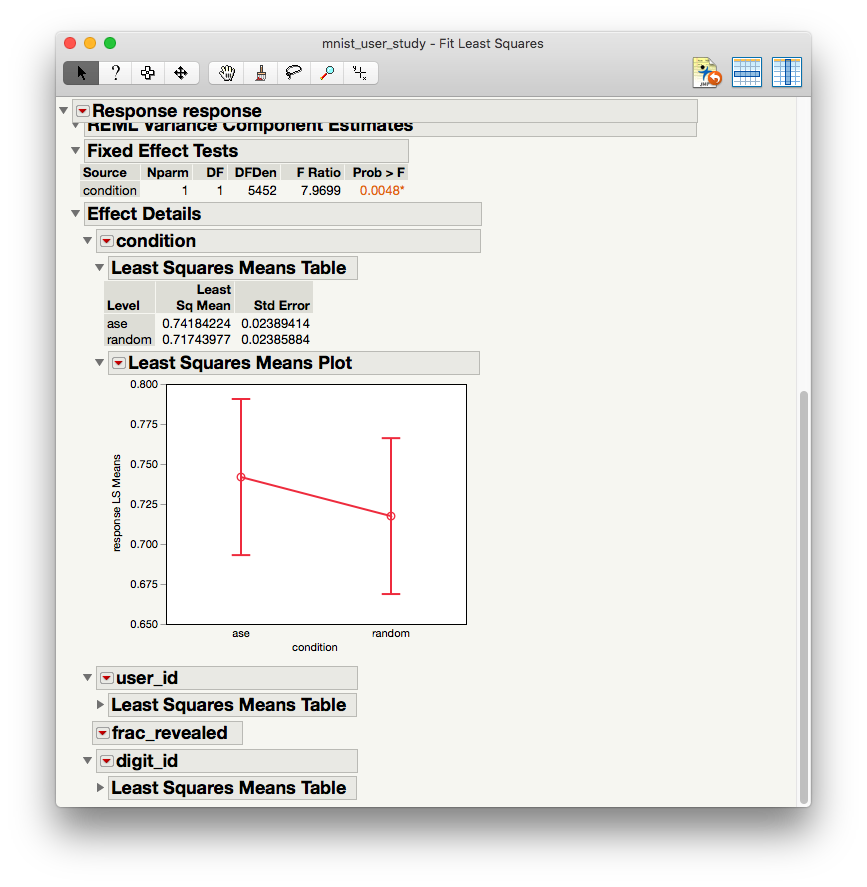

fit internal obs model

In [ ]:
unassisted_train_rollouts = utils.evaluate_policy(
  sess,
  guide_env,
  unif_guide_policy,
  n_eval_rollouts=500
)['rollouts']

In [ ]:
unassisted_rollouts_path = os.path.join(data_dir, 'unassisted_rollouts.pkl')

In [ ]:
with open(unassisted_rollouts_path, 'wb') as f:
  pickle.dump(unassisted_train_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(unassisted_rollouts_path, 'rb') as f:
  unassisted_train_rollouts = pickle.load(f)

In [ ]:
naive_assisted_train_rollouts = utils.evaluate_policy(
  sess,
  guide_env,
  naive_guide_model,
  n_eval_rollouts=500
)['rollouts']

In [ ]:
naive_assisted_rollouts_path = os.path.join(data_dir, 'naive_assisted_rollouts.pkl')

In [ ]:
with open(naive_assisted_rollouts_path, 'wb') as f:
  pickle.dump(naive_assisted_train_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(naive_assisted_rollouts_path, 'rb') as f:
  naive_assisted_train_rollouts = pickle.load(f)

In [ ]:
init_train_rollouts = unassisted_train_rollouts

In [ ]:
init_train_rollouts.extend(naive_assisted_train_rollouts)

In [ ]:
guide_model_kwargs = {
  'scope_file': os.path.join(data_dir, 'guide_scope.pkl'),
  'tf_file': os.path.join(data_dir, 'guide.tf'),
  'n_hidden': 32,
  'n_layers': 0,
  'final_action_only': False
}

guide_train_kwargs = {
  'iterations': 5000,
  'ftol': 1e-4,
  'batch_size': 32,
  'learning_rate': 1e-2,
  'val_update_freq': 100,
  'verbose': True
}

encoder_for_guide = EncoderUserObsModel(sess, env, **guide_model_kwargs)

guide_model = CLFGuide(
  sess,
  env,
  encoder_for_guide
)

In [ ]:
guide_optimizer = ase.InteractiveGuideOptimizer(sess, env, guide_env)

In [ ]:
n_reps = 5

In [ ]:
train_logs = [guide_optimizer.run(
  guide_model, 
  n_train_batches=20, 
  n_rollouts_per_batch=500, 
  guide_train_kwargs=guide_train_kwargs,
  verbose=True,
  init_train_rollouts=init_train_rollouts,
  n_eval_rollouts=1000
) for _ in range(n_reps)]

In [ ]:
train_logs_path = os.path.join(data_dir, 'train_logs.pkl')

In [ ]:
with open(train_logs_path, 'wb') as f:
  pickle.dump(train_logs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(train_logs_path, 'rb') as f:
  train_logs = pickle.load(f)

In [ ]:
for metric in ['succ', 'user_belief_in_true_state']:
  plt.title('MNIST')
  plt.xlabel(r'Number of Training Episodes ($|\mathcal{D}|$)')
  ylabel = label_of_perf_met[metric]
  plt.ylabel(ylabel)
  
  guide_name = 'learned'
  label = utils.label_of_guide[guide_name]
  color = utils.color_of_guide[guide_name]
  utils.plot_perf_evals([train_log['guide_perf_evals'] for train_log in train_logs], 'n_train_rollouts', metric, color=color, label=label)
  
  for guide_name, guide_eval in baseline_guide_evals.items():
    if guide_name == 'oracle':
      continue
    ys = guide_eval['perf'][metric]
    label = utils.label_of_guide[guide_name]
    color = utils.color_of_guide[guide_name]
    linestyle = '-' if guide_name == 'oracle' else '--'
    plt.axhline(y=baseline_guide_evals[guide_name]['perf'][metric], label=label, color=color, linestyle=linestyle, linewidth=2)
  
  plt.legend(loc='lower right', prop={'size': 12})
  save_path = os.path.join(fig_dir, '%s_%s_vs_trainsize.pdf' % ('clf', metric))
  plt.savefig(save_path, bbox_inches='tight')
  plt.show()

In [ ]:
rollouts = sum([train_log['train_rollouts'][-500:] for train_log in train_logs], [])
learned_perf = utils.compute_perf_metrics(rollouts, env)

In [ ]:
for metric in ['succ', 'user_belief_in_true_state']:
  plt.title('MNIST')
  plt.xlabel('Fraction of Image Revealed')
  ylabel = label_of_perf_met[metric]
  plt.ylabel(ylabel)
  
  for guide_name in ['iden', 'unif', 'naive', 'oracle']:
    if guide_name == 'oracle':
      guide_eval = {'perf': learned_perf}
    else:
      guide_eval = baseline_guide_evals[guide_name]
    xs = np.arange(1, max_ep_len + 1, 1) / max_ep_len
    ys = np.array(guide_eval['perf']['%s_t' % metric])
    yerrs = np.array(guide_eval['perf']['%s_stderr_t' % metric])
    if guide_name == 'naive':
      color = 'teal'
    elif guide_name == 'oracle':
      label = 'ASE (Our Method)'
      color = 'orange'
    else:
      label = utils.label_of_guide[guide_name]
      color = utils.color_of_guide[guide_name]
    plt.errorbar(x=xs, y=ys, yerr=yerrs, label=label, color=color, capsize=2)

  plt.legend(loc='lower right', prop={'size': 12})
  save_path = os.path.join(fig_dir, '%s_%s.pdf' % ('clf', metric))
  plt.savefig(save_path, bbox_inches='tight')
  plt.show()